In [1]:
from pprint import pprint
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs
import xml.etree.ElementTree as ET
%matplotlib inline
style.use('fivethirtyeight')

## Load XML data

In [2]:
url_root = 'https://www.usada.org/uploads/web_hist_files/xml/'
years = list(range(2015,2019))

urls = [url_root + str(yr) + 'all.xml' for yr in years]
yr_bytes = [requests.get(u).content for u in urls]

In [3]:
print(urls)

['https://www.usada.org/uploads/web_hist_files/xml/2015all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2016all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2017all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2018all.xml']


In [4]:
for y in yr_bytes:
    print(y[:200])
    print('\n\n')

b'<TestHistory><TREC><YR>2015</YR><QTR>All</QTR><AName>Madeline Aaron</AName><NumTests>2</NumTests><Sport>Figure Skating</Sport><AFN>Madeline</AFN><ALN>Aaron</ALN></TREC><TREC><YR>2015</YR><QTR>All</QTR'



b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x000\x001\x006\x00<\x00/\x00Y\x00R\x00>\x00<\x00Q\x00T\x00R\x00>\x00A\x00l\x00l\x00<\x00/\x00Q\x00T\x00R\x00>\x00<\x00A\x00N\x00a\x00m\x00e\x00>\x00J\x00e\x00s\x00s\x00i\x00c\x00a\x00 \x00(\x00P\x00i\x00x\x00l\x00e\x00r\x00)\x00 \x00T\x00e\x00b\x00o\x00<\x00/\x00A\x00N\x00a\x00m\x00e\x00>\x00<\x00N\x00u\x00m\x00T\x00e\x00s\x00t\x00s\x00>\x001\x00<\x00/\x00N\x00u\x00m\x00T\x00'



b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x000\x001\x007\x00<\x00/\x00Y\x00R\x00>\x00<\x00Q\x00T\x00R\x00>\x00A\x00l\x00l\x00<\x00/\x00Q\x00T\x00R\x00>\x00<\x00A\x00N\x00a\x00m\x00e\x00>\x00M\x00a\x

## Parsing XML to DF

In [5]:
roots = {}
athletes = {}
dfs = {}

# Create dict of xml root elements for each year. 
for i, y in enumerate(years):
    roots[y] = ET.fromstring(yr_bytes[i])
    athletes[y] = []
    
    # Filter by sport to create list of athlete dicts for each year.
    for child in roots[y]:
        player_dict = {
            'year': child[0].text,
            'sport': child[4].text,
            'fname': child[5].text,
            'lname': child[6].text,
            'tests': child[3].text
        }
        athletes[y].append(player_dict)
        
    # Create dataframe for each year
    dfs[y] = pd.DataFrame(athletes[y])
    dfs[y] = dfs[y].astype({'tests': 'int64', 'year': 'int64'})

In [6]:
for df in dfs.values():
    print(df.head(), '\n')

      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating      1  2015 

      fname          lname              sport  tests  year
0   Jessica  (Pixler) Tebo    Track and Field      1  2016
1  Madeline          Aaron     Figure Skating      1  2016
2       Max          Aaron     Figure Skating      2  2016
3     Mason        Abbiate  Paralympic Soccer      1  2016
4      Mara         Abbott            Cycling      8  2016 

       fname         lname                 sport  tests  year
0        Max         Aaron        Figure Skating      3  2017
1       Mara        Abbott               Cycling      5  2017
2     Taylor        Abbott              Swimming      2  2017
3  Abdihakim    Abdirahman       Track and Field     10  2017
4     Hakeem  

In [7]:
for d in dfs.values():
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=False).head(10), '\n')
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=True).head(10), '\n\n')

        fname      lname               sport  tests  year
2564    Ronda     Rousey  Mixed Martial Arts      8  2015
29       Jose       Aldo  Mixed Martial Arts      8  2015
1990    Conor   McGregor  Mixed Martial Arts      8  2015
1282      Dan  Henderson  Mixed Martial Arts      7  2015
1371    Holly       Holm  Mixed Martial Arts      7  2015
647   Antonio   Da Silva  Mixed Martial Arts      7  2015
2536     Yoel     Romero  Mixed Martial Arts      6  2015
2509     Luke   Rockhold  Mixed Martial Arts      6  2015
774    Rafael  Dos Anjos  Mixed Martial Arts      6  2015
184     Vitor    Belfort  Mixed Martial Arts      6  2015 

       fname      lname               sport  tests  year
24     Omari   Akhmedov  Mixed Martial Arts      1  2015
2169     Roy     Nelson  Mixed Martial Arts      1  2015
2121  Gegard    Mousasi  Mixed Martial Arts      1  2015
2083  Takeya   Mizugaki  Mixed Martial Arts      1  2015
1967  Tamdan    McCrory  Mixed Martial Arts      1  2015
1931   Jorge   Mas

In [8]:
# Filter to mma only and combine into 1 df
mma = pd.concat([df.loc[df.sport=='Mixed Martial Arts',:] for df in dfs.values()], axis=0)\
    .drop('sport', axis=1)
sports = pd.concat([df.loc[df.sport!='Mixed Martial Arts',:] for df in dfs.values()], axis=0)

In [9]:
def partial_year_percent(cell):
    '''Calculate % of year under USADA since some are <365 (first year of program
    and current year in progress).'''
    if cell == 2015:
        years = (datetime.date(2016, 1, 1) - start_date).days / 365
    elif cell == end_date.year:
        years = (end_date - datetime.date(end_date.year-1, 12, 31)).days / 365
    else:
        years = 1
    return years

In [10]:
start_date = datetime.date(2015, 7, 1)
end_date = datetime.date.today()
mma['year_percent'] = mma['year'].apply(partial_year_percent)

In [11]:
mma['req_tests'] = np.maximum(mma['tests'] - 2, 0)
mma['scaled_tests'] = mma['tests'] / mma['year_percent']
mma['scaled_req_tests'] = np.maximum(mma['scaled_tests'] - 2, 0)
mma['name'] = mma['fname'] + ' ' + mma['lname']

In [12]:
print(mma.head())
print(sports.head())

     fname     lname  tests  year  year_percent  req_tests  scaled_tests  \
24   Omari  Akhmedov      1  2015       0.50411          0      1.983696   
29    Jose      Aldo      8  2015       0.50411          6     15.869565   
41   Eddie   Alvarez      2  2015       0.50411          0      3.967391   
44  Thiago     Alves      5  2015       0.50411          3      9.918478   
50   Corey  Anderson      1  2015       0.50411          0      1.983696   

    scaled_req_tests            name  
24          0.000000  Omari Akhmedov  
29         13.869565       Jose Aldo  
41          1.967391   Eddie Alvarez  
44          7.918478    Thiago Alves  
50          0.000000  Corey Anderson  
      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating     

In [13]:
# Spread columns into new df (experimenting).
mma_spread = mma.pivot_table(index=['name', 'fname', 'lname'], columns='year',
     values=['tests', 'scaled_tests', 'req_tests', 'scaled_req_tests']).reset_index()
mma_spread.head()

name        fname           lname req_tests            \
year                                                         2015 2016 2017   
0     Abdul Razak Alhassan        Abdul  Razak Alhassan       NaN  NaN  2.0   
1       Abdul-Kerim Edilov  Abdul-Kerim          Edilov       NaN  0.0  2.0   
2            Abel Trujillo         Abel        Trujillo       2.0  4.0  1.0   
3              Abu Azaitar          Abu         Azaitar       NaN  NaN  NaN   
4              Adam Hunter         Adam          Hunter       NaN  0.0  NaN   

          scaled_req_tests                     scaled_tests            \
year 2018             2015 2016 2017      2018         2015 2016 2017   
0     0.0              NaN  NaN  2.0  2.591195          NaN  NaN  4.0   
1     NaN              NaN  0.0  2.0       NaN          NaN  2.0  4.0   
2     NaN         5.934783  4.0  1.0       NaN     7.934783  6.0  3.0   
3     0.0              NaN  NaN  NaN  0.295597          NaN  NaN  NaN   
4     NaN              NaN  0.0  NaN       NaN          NaN  2.0  NaN   

               tests                 
year      2018  2015 2016 2017 2018  
0     4.591195   NaN  NaN  4.0  2.0  
1          NaN   NaN  2.0  4.0  NaN  
2          NaN   4.0  6.0  3.0  NaN  
3     2.295597   NaN  NaN  NaN  1.0  
4          NaN   NaN  2.0  NaN  NaN

In [14]:
# Fighters tested at least once each year since start of program.
all_years = mma_spread.loc[mma_spread.tests.isnull().sum(axis=1) == 0][['name', 'tests']]

print(str(round(100 * all_years.shape[0] / mma_spread.shape[0], 2)) + '%')

12.84%


In [15]:
# testing possible colnames to remove multi-index
[group + '_' + str(col)[-2:] for group, col in mma_spread.columns.values]
[group + '_' + str(col)[-2:] if col else group for group, col in mma_spread.columns.values]

['name',
 'fname',
 'lname',
 'req_tests_15',
 'req_tests_16',
 'req_tests_17',
 'req_tests_18',
 'scaled_req_tests_15',
 'scaled_req_tests_16',
 'scaled_req_tests_17',
 'scaled_req_tests_18',
 'scaled_tests_15',
 'scaled_tests_16',
 'scaled_tests_17',
 'scaled_tests_18',
 'tests_15',
 'tests_16',
 'tests_17',
 'tests_18']

In [16]:
fighter_totals = mma['tests'].groupby([mma.name]).sum().sort_values(ascending=False)

print(fighter_totals.head(25))
print(fighter_totals.tail(10))

name
Holly Holm            35
Yoel Romero           35
Rafael Dos Anjos      34
Cristiane Justino     33
Vitor Belfort         33
Daniel Cormier        33
Eddie Alvarez         32
Dominick Cruz         29
Stipe Miocic          29
Edson Barboza         29
Fabricio Werdum       28
Anderson Silva        28
Conor McGregor        28
Robbie Lawler         28
Frank Edgar           27
Tyron Woodley         27
TJ Dillashaw          27
Tecia Torres          27
Stephen Thompson      27
Dustin Poirier        26
Amanda Nunes          26
Jose Aldo             26
Chris Weidman         25
Ovince Saint Preux    25
Demetrious Johnson    25
Name: tests, dtype: int64
name
Ariel Beck                 1
James Te Huna              1
Song Yadong                1
Milana Dudieva             1
Renato Moicano             1
Mark Anthony De La Rosa    1
Michal Oleksiejczuk        1
Shawn Jordan               1
Michael Wilkinson          1
Dan Castillo               1
Name: tests, dtype: int64


In [17]:
grouped_avg = mma[['tests', 'scaled_tests', 'req_tests', 'scaled_req_tests']].groupby(mma.year)\
    .agg([np.mean, np.sum, len])
grouped_avg

tests            scaled_tests                     req_tests        \
          mean   sum  len         mean          sum    len      mean   sum   
year                                                                         
2015  2.262821   353  156     4.488747   700.244565  156.0  0.730769   114   
2016  3.907850  2290  586     3.907850  2290.000000  586.0  2.076792  1217   
2017  4.524880  2819  623     4.524880  2819.000000  623.0  2.653291  1653   
2018  2.171171  1205  555     4.984135  2766.194969  555.0  0.491892   273   

          scaled_req_tests                      
      len             mean          sum    len  
year                                            
2015  156         2.496377   389.434783  156.0  
2016  586         2.076792  1217.000000  586.0  
2017  623         2.653291  1653.000000  623.0  
2018  555         2.984135  1656.194969  555.0

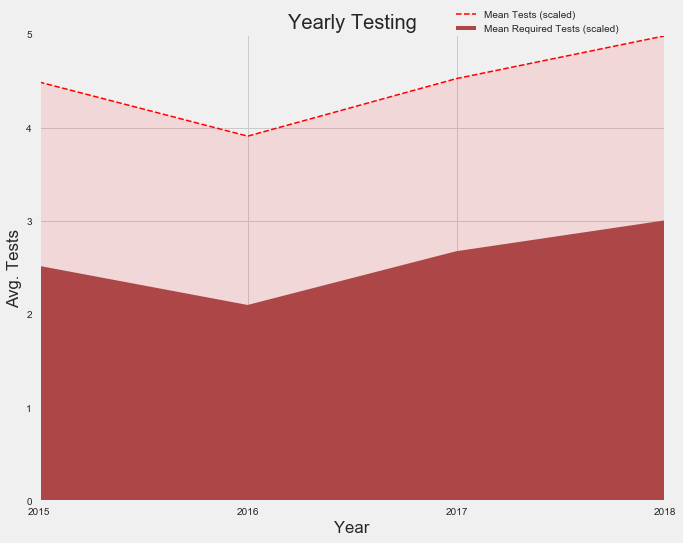

In [18]:
scaled_means = grouped_avg['scaled_tests']['mean'].values
scaled_req_means = grouped_avg['scaled_req_tests']['mean'].values

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(years, scaled_means, color='red', ls='--', lw=1.5, label='Mean Tests (scaled)')
ax.plot(years, scaled_req_means, color='#ad4747', label='Mean Required Tests (scaled)')
ax.fill_between(years, scaled_means, scaled_req_means, alpha=0.1, color='red')
ax.fill_between(years, scaled_req_means, 0, color='#ad4747')
plt.xlim(start_date.year, end_date.year)
plt.xticks(years)
plt.xlabel('Year')
plt.ylim(0, 5)
plt.ylabel('Avg. Tests')
plt.title('Yearly Testing')
plt.legend(loc='upper right', bbox_to_anchor=(.94, 1.07))
plt.show()

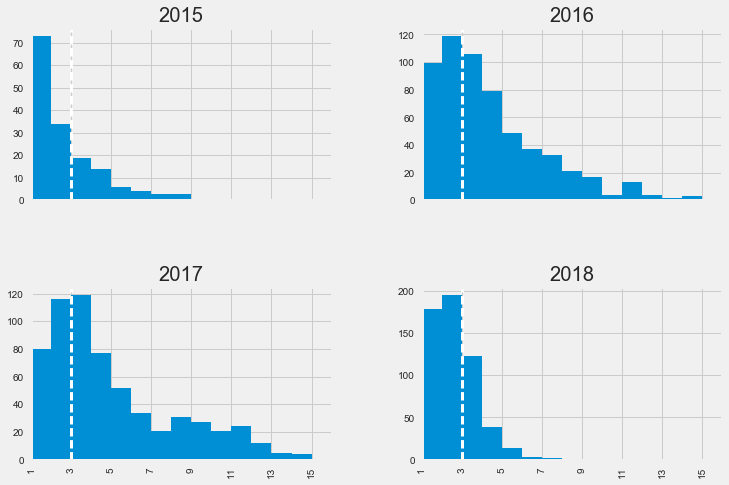

In [40]:
g = mma.hist('tests', by='year', figsize=(12,8), sharex=True, bins=range(16))
for row in g:
    for sub in row:
        sub.axvline(3, ls='--', lw=3, color='white')
plt.xticks(range(1, 17, 2))
plt.xlim(1, 16)
plt.show()

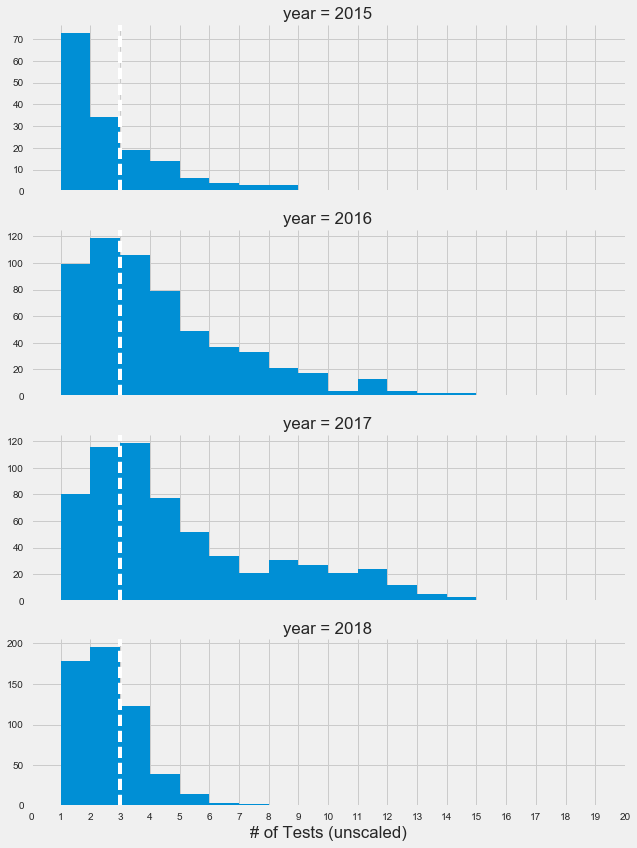

In [30]:
g = sns.FacetGrid(mma, row='year', size=3, aspect=3, sharex=True, sharey=False)
g = g.map(plt.hist, 'tests', bins=range(21))
plt.xlim(0, 20)
plt.xticks(range(21))
plt.xlabel('# of Tests (unscaled)')
for ax in g.axes:
    ax[0].axvline(3, ls='--', color='white')
plt.show()

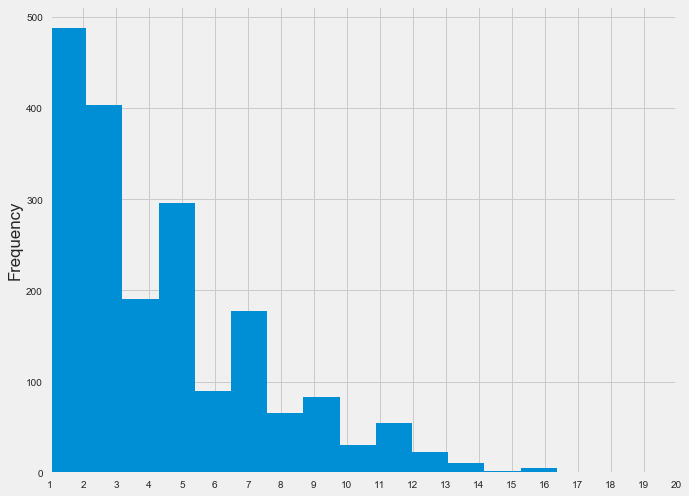

In [21]:
mma['scaled_tests'].plot.hist(figsize=(10,8), bins=20)
plt.xlim(1, 20)
plt.xticks(range(1,21))
plt.show()

In [42]:
# testing - find various percentiles for each year
percentiles = [5, 25, 50, 75, 99]
for p in percentiles:
    print('\n' + str(p))
    print(mma['scaled_tests'].groupby(mma.year).agg(lambda x: np.percentile(x, q=p)))


5
year
2015    1.983696
2016    1.000000
2017    1.000000
2018    2.295597
Name: scaled_tests, dtype: float64

25
year
2015    1.983696
2016    2.000000
2017    2.000000
2018    2.295597
Name: scaled_tests, dtype: float64

50
year
2015    3.967391
2016    3.000000
2017    3.000000
2018    4.591195
Name: scaled_tests, dtype: float64

75
year
2015    5.951087
2016    5.000000
2017    6.000000
2018    6.886792
Name: scaled_tests, dtype: float64

99
year
2015    15.869565
2016    12.000000
2017    13.000000
2018    12.533962
Name: scaled_tests, dtype: float64


In [23]:
rows = mma.shape[0]
for i in range(1,10):
    print('<={} tests: {}'.format(i, round(mma.loc[mma.tests<=i, :].shape[0]/rows, 2)))
    print('<={} required tests: {}\n'.format(i, round(mma.loc[mma.req_tests<=i, :]\
                                                      .shape[0]/rows, 2)))

<=1 tests: 0.22
<=1 required tests: 0.66

<=2 tests: 0.47
<=2 required tests: 0.77

<=3 tests: 0.66
<=3 required tests: 0.83

<=4 tests: 0.77
<=4 required tests: 0.87

<=5 tests: 0.83
<=5 required tests: 0.9

<=6 tests: 0.87
<=6 required tests: 0.93

<=7 tests: 0.9
<=7 required tests: 0.95

<=8 tests: 0.93
<=8 required tests: 0.97

<=9 tests: 0.95
<=9 required tests: 0.98



In [48]:
mma_spread.reset_index(drop=True)

name        fname            lname req_tests       \
year                                                            2015 2016   
0       Abdul Razak Alhassan        Abdul   Razak Alhassan       NaN  NaN   
1         Abdul-Kerim Edilov  Abdul-Kerim           Edilov       NaN  0.0   
2              Abel Trujillo         Abel         Trujillo       2.0  4.0   
3                Abu Azaitar          Abu          Azaitar       NaN  NaN   
4                Adam Hunter         Adam           Hunter       NaN  0.0   
5               Adam Khaliev         Adam          Khaliev       NaN  0.0   
6              Adam Milstead         Adam         Milstead       NaN  0.0   
7             Adam Wieczorek         Adam        Wieczorek       NaN  NaN   
8            Adriano Martins      Adriano          Martins       NaN  2.0   
9             Aiemann Zahabi      Aiemann           Zahabi       NaN  0.0   
10              Aisling Daly      Aisling             Daly       NaN  1.0   
11               Al Iaquinta           Al         Iaquinta       NaN  1.0   
12               Alan Jouban         Alan           Jouban       0.0  2.0   
13              Alan Patrick         Alan          Patrick       NaN  0.0   
14            Albert Morales       Albert          Morales       NaN  1.0   
15            Albert Tumenov       Albert          Tumenov       0.0  4.0   
16              Alberto Mina      Alberto             Mina       NaN  0.0   
17               Alberto Uda      Alberto              Uda       NaN  0.0   
18           Alejandro Perez    Alejandro            Perez       NaN  4.0   
19          Aleksander Rakic   Aleksander            Rakic       NaN  NaN   
20           Aleksei Oleinik      Aleksei          Oleinik       NaN  0.0   
21        Alessio Di Chirico      Alessio       Di Chirico       NaN  0.0   
22              Alex Caceres         Alex          Caceres       NaN  2.0   
23             Alex Chambers         Alex         Chambers       0.0  0.0   
24          Alex De Oliveira         Alex      De Oliveira       0.0  1.0   
25               Alex Enlund         Alex           Enlund       NaN  NaN   
26               Alex Garcia         Alex           Garcia       NaN  6.0   
27               Alex Morono         Alex           Morono       NaN  3.0   
28            Alex Nicholson         Alex        Nicholson       NaN  2.0   
29                Alex Reyes         Alex            Reyes       NaN  NaN   
..                       ...          ...              ...       ...  ...   
780            Vitor Miranda        Vitor          Miranda       NaN  1.0   
781          Viviane Pereira      Viviane          Pereira       NaN  0.0   
782          Volkan Oezdemir       Volkan         Oezdemir       NaN  NaN   
783   Von Kurt Holobaugh Jr.     Von Kurt    Holobaugh Jr.       NaN  NaN   
784              Walt Harris         Walt           Harris       NaN  2.0   
785            Warlley Alves      Warlley            Alves       NaN  2.0   
786       Warlley De Andrade      Warlley       De Andrade       0.0  NaN   
787              Will Brooks         Will           Brooks       NaN  5.0   
788             Willie Gates       Willie            Gates       NaN  0.0   
789              Wilson Reis       Wilson             Reis       NaN  5.0   
790             Wuliji Buren       Wuliji            Buren       NaN  NaN   
791           Yair Rodriguez         Yair        Rodriguez       NaN  6.0   
792               Yan Cabral          Yan           Cabral       NaN  0.0   
793              Yan Xiaonan          Yan          Xiaonan       NaN  NaN   
794          Yana Kunitskaya         Yana       Kunitskaya       NaN  NaN   
795                 Yanan Wu        Yanan               Wu       NaN  NaN   
796           Yancy Medeiros        Yancy         Medeiros       NaN  1.0   
797               Yao Zhikui          Yao           Zhikui       NaN  0.0   
798             Yaotzin Meza      Yaotzin             Meza       NaN  0.0   
799               Ya

Idea: Scrape sherdog/wikipedia/fightmatrix/fightmetric/ufci api to find # of fights in UFC each year. This should give a decent approximation of roster size (there will still be some misclassifications with fighters being injured or taking a long time between fights for whatever reason). We want to be able to distinguish between NaN and zero - in other words, was a fighter not in the UFC that year, or were they in the UFC but weren't tested?

In addition, this will give us another factor to analyze in relation to testing #s. We might guess
that USADA is more likely to test those who are scheduled to fight. We can also look at win/loss
records to see if that plays a role (better fighters tested more?). We could also scrape rankings to
check for a similar effect there. 

Other ideas:
-  see if test dates are available somewhere
    -  spread out vs close together?
    -  increase/decrease after a loss?
    -  evenly spaced or unpredictable/variable width?
-  twitter/instagram followers - are more popular fighters targeted?
    -  not sure if historical follower counts available
-  see if test failures are available
-  add nationality (wikipedia?)
-  add fight camp
-  add weight class
-  add previous failures (true/false)
-  add "eye test" (i.e. call out a few obvious examples, leave rest False)
-  add number of title fights

In [66]:
mma_spread.loc[mma_spread.lname == 'Araujo']

Empty DataFrame
Columns: [(name, ), (fname, ), (lname, ), (req_tests, 2015), (req_tests, 2016), (req_tests, 2017), (req_tests, 2018), (scaled_req_tests, 2015), (scaled_req_tests, 2016), (scaled_req_tests, 2017), (scaled_req_tests, 2018), (scaled_tests, 2015), (scaled_tests, 2016), (scaled_tests, 2017), (scaled_tests, 2018), (tests, 2015), (tests, 2016), (tests, 2017), (tests, 2018)]
Index: []

## Comparison w/ other sports

In [24]:
sports_means = sports['tests'].groupby(sports.sport).agg([np.mean, np.sum, len])\
    .sort_values('mean', ascending=False)
    
print(sports_means.head())
print(sports_means.tail())

                          mean   sum  len
sport                                    
Professional Boxing  11.134328   746   67
Speedskating          2.888372   621  215
Tennis                2.768293   227   82
Swimming              2.653226  1974  744
Biathlon              2.596154   135   52
                        mean  sum  len
sport                                 
Field Hockey        1.045045  116  111
Sailing             1.035088   59   57
Water Skiing        1.023810   43   42
Paralympic Fencing  1.000000    2    2
Paralympic Boccia   1.000000    9    9
